<a href="https://colab.research.google.com/github/ANNDO/RegressaoLinear-ConsumoDeCerveja/blob/main/regressao_linear_consumo_cerveja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Estudo sobre regressão linear usando dataset "Beer Consumption - Sao Paulo"**

O objetivo deste trabalho é estudar modelos de regressão linear através do uso de um [dataset de consumo de cerveja.](https://www.kaggle.com/dongeorge/beer-consumption-sao-paulo) O dataset disponibiliza o consumo em litros de cerveja registrado por dia em uma região de bares universitários na cidade de São Paulo. Além disso, ele possui os registros diários de temperatura (máxima, mínima e média), precipitação e fim de semana (anotado como 1) ou não (anotado com 0). 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge,Lasso,LassoCV
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict,TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nomeArquivo = 'Consumo_cerveja.csv'
dataset = pd.read_csv(nomeArquivo,parse_dates=True)

In [3]:
pd.set_option('display.max_columns', None)
print(dataset.head())
print(dataset.columns)

         Data Temperatura Media (C) Temperatura Minima (C)  \
0  2015-01-01                  27,3                   23,9   
1  2015-01-02                 27,02                   24,5   
2  2015-01-03                 24,82                   22,4   
3  2015-01-04                 23,98                   21,5   
4  2015-01-05                 23,82                     21   

  Temperatura Maxima (C) Precipitacao (mm)  Final de Semana  \
0                   32,5                 0              0.0   
1                   33,5                 0              0.0   
2                   29,9                 0              1.0   
3                   28,6               1,2              1.0   
4                   28,3                 0              0.0   

   Consumo de cerveja (litros)  
0                       25.461  
1                       28.972  
2                       30.814  
3                       29.799  
4                       28.900  
Index(['Data', 'Temperatura Media (C)', 'Temperatu

Exitem sete colunas, porém apenas duas são interpretadas como número:

In [4]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         365 non-null    object 
 1   Temperatura Media (C)        365 non-null    object 
 2   Temperatura Minima (C)       365 non-null    object 
 3   Temperatura Maxima (C)       365 non-null    object 
 4   Precipitacao (mm)            365 non-null    object 
 5   Final de Semana              365 non-null    float64
 6   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(2), object(5)
memory usage: 51.6+ KB
None


Outra observação relevante retirada da saída acima é que existem 941 linhas, entretanto apenas 365 não são nulas.

In [5]:
print(dataset.tail())

    Data Temperatura Media (C) Temperatura Minima (C) Temperatura Maxima (C)  \
936  NaN                   NaN                    NaN                    NaN   
937  NaN                   NaN                    NaN                    NaN   
938  NaN                   NaN                    NaN                    NaN   
939  NaN                   NaN                    NaN                    NaN   
940  NaN                   NaN                    NaN                    NaN   

    Precipitacao (mm)  Final de Semana  Consumo de cerveja (litros)  
936               NaN              NaN                          NaN  
937               NaN              NaN                          NaN  
938               NaN              NaN                          NaN  
939               NaN              NaN                          NaN  
940               NaN              NaN                          NaN  


Como a temperatura e o nível de chuva variam ao longo do ano, faz-se necessário investigar onde estão os dados nulos para verificar se existe predominânica de registro em um perído do ano.

Text(0.5, 0.1, 'último: 2015-12-31')

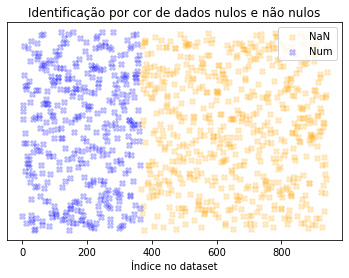

<Figure size 432x288 with 0 Axes>

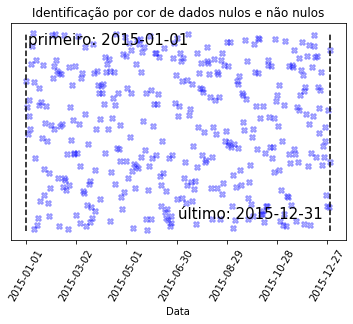

In [6]:
indicesNulos = dataset['Consumo de cerveja (litros)'].isna()
listaNaN = dataset[indicesNulos].index.tolist()
listaNum = dataset[~indicesNulos].index.tolist()

plt.figure(1)
plt.scatter(listaNaN,np.random.random(len(listaNaN))*2,marker='X',c='orange',alpha=0.2)
plt.scatter(listaNum,np.random.random(len(listaNum))*2,marker='X',c='b',alpha=0.2)
plt.xlabel('Índice no dataset')
plt.legend(['NaN','Num'],loc='upper right')
plt.tick_params(axis='y',which='both',left=False,bottom=False,labelleft=False)
plt.title('Identificação por cor de dados nulos e não nulos')

plt.figure(2)
fig,ax = plt.subplots(1,1)
plt.scatter(dataset.iloc[listaNum,0],np.random.random(len(listaNum))*2,marker='X',c='b',alpha=0.3)
primeiroRegistroNum = dataset.iloc[listaNum[0],0]
ultimoRegistroNum = dataset.iloc[listaNum[-1],0]
plt.plot([primeiroRegistroNum,primeiroRegistroNum],[0,2],c='black',linestyle='--')
plt.plot([ultimoRegistroNum,ultimoRegistroNum],[0,2],c='black',linestyle='--')
plt.xlabel('Data')
plt.title('Identificação por cor de dados nulos e não nulos')
plt.tick_params(axis='y',which='both',left=False,bottom=False,labelleft=False)
ax.xaxis.set_major_locator(MaxNLocator(8)) 
plt.tick_params(labelrotation=60)
ax.annotate('primeiro: {}'.format(dataset.iloc[listaNum[0],0]),xy=(0.05, 0.9), xycoords='axes fraction',fontsize=15)
ax.annotate('último: {}'.format(dataset.iloc[listaNum[-1],0]),xy=(0.50, 0.1), xycoords='axes fraction',fontsize=15)


Os gráficos acima evidenciam que os registros válidos estão apenas entre as primeiras 365 entradas e portanto compreendem um ano de registros consecutivos, entre 01 de janeiro de 2015 e 31 de dezembro de 2015. Por essa razão, é razoável que todas linhas nulas sejam eliminadas: 



In [7]:
dsPreprocessado = dataset
dsPreprocessado = dataset.dropna()

As colunas de 1 a 4 deveriam ser interpretadas como número. Isso não ocorre porque os número foram registrados com ',' para indicar as casas decimais em vez de usar '.':

In [8]:
dsPreprocessador = dsPreprocessado.replace(',','.',inplace=True,regex=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


A coluna 'Data' não traz informação relevante para o resto desta análise, portanto pode ser descartada:

In [9]:
dsPreprocessado = dsPreprocessado.drop(columns='Data')


Tendo substituído as vírgulas por pontos, podemos transformar as colunas identificadas como 'object' em 'float64':

In [10]:
dsPreprocessado.iloc[:,0:4] = dsPreprocessado.iloc[:,0:4].apply(pd.to_numeric)
dsPreprocessado.iloc[:,4] = dsPreprocessado.iloc[:,4].astype(int)# apply(pd.to_numeric(downcast='int'))
print(dsPreprocessado.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temperatura Media (C)        365 non-null    float64
 1   Temperatura Minima (C)       365 non-null    float64
 2   Temperatura Maxima (C)       365 non-null    float64
 3   Precipitacao (mm)            365 non-null    float64
 4   Final de Semana              365 non-null    int64  
 5   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 20.0 KB
None


In [11]:
print(dsPreprocessado.describe())

       Temperatura Media (C)  Temperatura Minima (C)  Temperatura Maxima (C)  \
count             365.000000              365.000000              365.000000   
mean               21.226356               17.461370               26.611507   
std                 3.180108                2.826185                4.317366   
min                12.900000               10.600000               14.500000   
25%                19.020000               15.300000               23.800000   
50%                21.380000               17.900000               26.900000   
75%                23.280000               19.600000               29.400000   
max                28.860000               24.500000               36.500000   

       Precipitacao (mm)  Final de Semana  Consumo de cerveja (litros)  
count         365.000000       365.000000                   365.000000  
mean            5.196712         0.284932                    25.401367  
std            12.417844         0.452001                   

Agora podemos realizar análises sobre os dados relevantes utilizando recursos gráficos:

<Figure size 432x288 with 0 Axes>

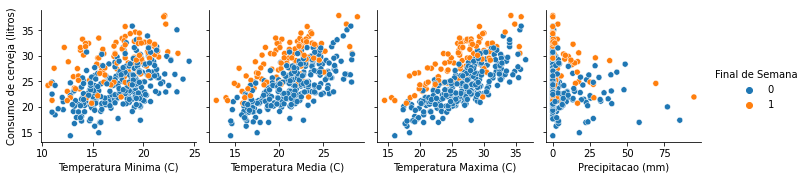

In [12]:
plt.figure(1)
sns.pairplot(dsPreprocessado,x_vars=['Temperatura Minima (C)','Temperatura Media (C)','Temperatura Maxima (C)','Precipitacao (mm)'],y_vars=['Consumo de cerveja (litros)'],hue='Final de Semana',diag_kind=None)


O consumo de cerveja tende a ser maior quando os termômetros registram maior temperatura.  O gráfico de precipitação mostra alta amplitude nos valores de consumo de cerveja para dias sem chuva. Essa amplitude é reduzida quanto maior o valor de precipitação, bem como o volume de cerveja consumido.

O gráfico abaixo relaciona o consumo com o fato do dia ser fim de semana (1) ou não (0). Percebe-se que a média de consumo de cerveja é maior nos finais de semana:

Text(0, 0.5, 'Consumo de cerveja [L]')

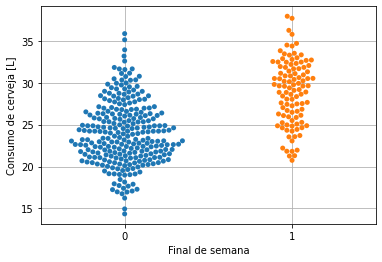

In [13]:
plt.figure(2)
sns.swarmplot(x='Final de Semana',y='Consumo de cerveja (litros)',data=dsPreprocessado)
plt.grid()
plt.xlabel('Final de semana')
plt.ylabel('Consumo de cerveja [L]')



O mapa de calor plotado abaixo oferece representação visual e numérica do grau de correlação entre os dados. 

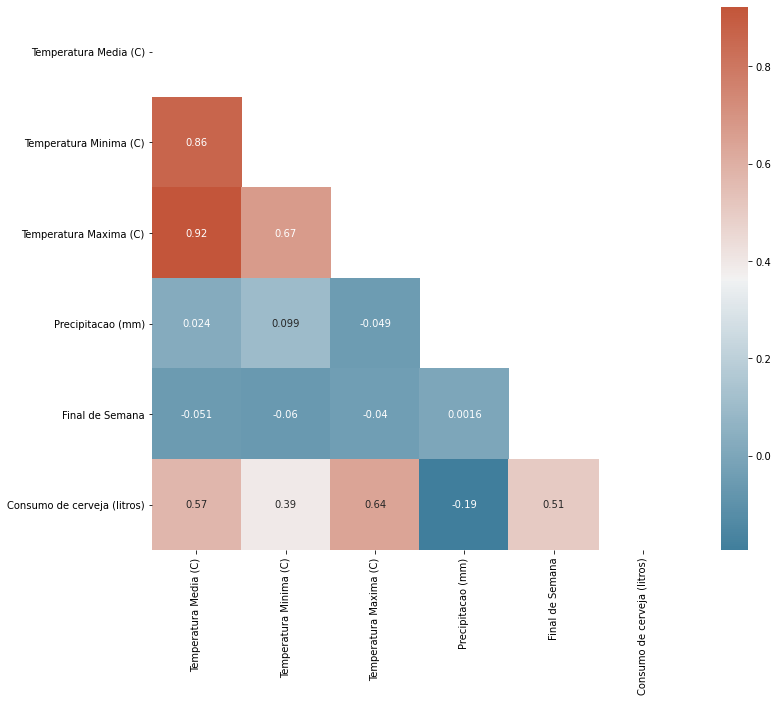

In [14]:
correlation = dsPreprocessado.corr()

f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle

mask = np.triu(np.ones_like(correlation,dtype=bool))

# Configure a custom diverging colormap

cmap = sns.diverging_palette(230, 20, as_cmap=True)


sns.heatmap(correlation,cmap=cmap,mask=mask,annot=True)


Valores próximos a 0 indicam baixa ou nenhuma correlação e valores próximos a 1 ou -1 refletem alta correlação, sendo o primeiro diretamente proporcional e o segundo inversamente proporcional. Vale ressaltar que, apesar da correlação medir a [intensidade de relação entre duas variáveis](https://medium.com/swlh/covariance-correlation-r-sqaured-5cbefc5cbe1c), isso não significa causalidade entre elas.

A partir das informações coletadas pode-se criar um modelo de predição baseado em regressão linear que calcule a quantidade de cerveja consumida em um dia considerando os dados de temperatura , precipitação e dia da semana. Em outras palavras, assume-se que temperatura, precipitação e dia da semana respeitam o modelamento de equação de reta:

$$y = \Theta^TX $$


Onde $y$ é o valor do consumo de cerveja, $\Theta$ é uma matriz que contém os coeficientes a serem calculados e $X$ é uma matriz com as valores de temperatura, precipitação e dia da semana.

Será utiliza a biblioteca [Scikit-learn](https://scikit-learn.org/stable/getting_started.html) para a criação de modelos.


In [15]:
reg = LinearRegression()
y = dsPreprocessado['Consumo de cerveja (litros)'].values #target
x = dsPreprocessado.drop(columns='Consumo de cerveja (litros)').values #fetures
xColunas = dsPreprocessado.drop(columns='Consumo de cerveja (litros)').columns

Caso usássemos todos os registros disponíveis no dataset para treinar o modelo, perderíamos a referência de como o modelo se comporta com dados desconhecidos. Por essa razão, faz-se necessário seperar os dados entre treinamento e teste  de forma pseudorandômica:

In [16]:
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=0.3,random_state=42)

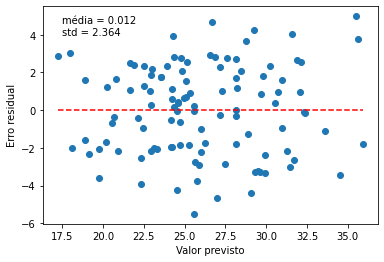

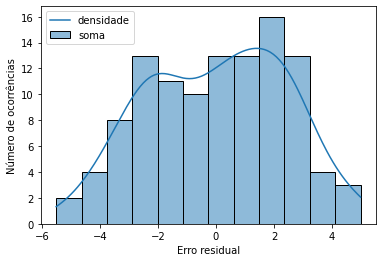

In [45]:
reg.fit(xTrain,yTrain)
yPred = reg.predict(xTest)
res = yPred - yTest
avgRes = round(np.mean(res),3)
stdRes = round(np.std(res),3)


plt.figure(1)
plt.scatter(yPred,res)
plt.plot([min(yPred),max(yPred)],[avgRes,avgRes],linestyle='--',c='red')
plt.xlabel('Valor previsto')
plt.ylabel('Erro residual')
plt.text(17.5,4,'média = {} \nstd = {}'.format(avgRes,stdRes))

plt.figure(2)
plt.xlabel('Erro residual')
plt.ylabel('Ocorrências')
sns.histplot(data=res,kde=True,bins=12)
plt.legend(['densidade','soma'])

Os gráficos acima mostram o resultado do erro residual, calculado pela subtração do valor observado e o valor estimado, ou ajustado:

$$e = y - \hat{y}$$

[Os resíduos devem estar centrados em 0 ao longo de todo a faixa de valores ajustados](https://blog.minitab.com/blog/adventures-in-statistics-2/why-you-need-to-check-your-residual-plots-for-regression-analysis). Nos interessa ter um conjunto de valores de erro residual com média próxima de 0 e com baixa dispersão.

Uma das métricas utilizadas para avaliar o desempenho do modelo é $R^2$, coeficiente de determinação, definida a seguir:

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Onde:

$$SS_{res} = \sum_{i=1}^n(y_i-\hat{y_{i}})^2$$ e $$SS_{tot} = \sum_{i=1}^n(y_i-\bar{y})^2$$

Sendo $y_i$ o i-ésimo valor observado,  $\hat{y_i}$ a i-ésima predição e $\bar{y}$ a média dos valores observados.

A inteção é que $R^2$ se aproxime de 1. Na prática isso significa que $\sum_{i=1}^n(y_i-\hat{y_{i}})^2 = \sum_{i=1}^ne_i^2$, chamado de 
[soma dos quadrados dos resíduos](https://pt.wikipedia.org/wiki/Coeficiente_de_determina%C3%A7%C3%A3o), será menor quanto melhor for o modelo adotado.


Para realizar comparação entre modelos não é indidcado o uso de $R^2$ pois ele [ aumenta com o aumento dos termos mesmo se o modelo não estiver realmente melhorando.](https://www.kdnuggets.com/2018/04/right-metric-evaluating-machine-learning-models-1.html) Isso significa que adicionar mais *features* ao modelo irá aumentar o valor de $R^2$, porém isso não quer dizer que a adição dessas *features* cria um modelo melhor.

O $R^2$ ajustado oferece melhor referência para comparação entre modelos:
$$R^2_{adj} = 1 - [\frac{(1-R^2)(n-1)}{n-k-1}]$$

Onde $n$ representa o número de *datapoints* e $k$ o número de variáveis independentes.

In [18]:
#função para calcular R2 ajustado
def calculaR2ajustado(r2Score,x):
  n = np.shape(x)[0]
  k = np.shape(x)[1]
  return 1 - (1-r2Score)*(n-1)/(n-k-1)

Outra métrica que será utilizada é MSE (*Mean Squared Error*), ou Erro Médio Quadrático:
$$ MSE = \frac{1}{n}\sum_{i=1}^n(y_i-\bar{y})^2$$




In [19]:
print('Valor de R2: {}'.format(reg.score(xTest,yTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTest,yPred)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(reg.score(xTest,yTest),xTest)))
print('Coeficientes da regressão: {}'.format(reg.coef_))
print('Intercept da regressão: {} \n'.format(reg.intercept_))


Valor de R2: 0.7437419586478452
Valor MSE: 5.589532075363928
Valor de R2 ajustado: 0.7314218605059146
Coeficientes da regressão: [ 0.22915007 -0.10521557  0.55878262 -0.05349757  5.33691137]
Intercept da regressão: 6.265398516782881 



Deve-se fazer uma investigação sobre quais parâmetros são relevantes na predição e se existe alguma relação intrínseca entre eles que possam afetar o modelo. Isso ocorre quando há colinearidade e multicolinearidade. Esse último é [um fenômeno no qual uma variável preditora em um modelo de regressão múltipla pode ser linearmente predito por outras com um substancial grau de acurária.](https://en.wikipedia.org/wiki/Multicollinearity)

Para medir a multicolinearidade existe o parâmetro *Variance Inflation Fator* (VIF):

$$ V.I.F. = 1 / (1 - R^2)$$

Deve-se calcular o VIF para cada variável e [se estiver entre 5 e 10 é provável que a multicolinearidade esteja presente e deve-se considerar descartar a variável.](https://etav.github.io/python/vif_factor_python.html)


In [20]:
vif = [variance_inflation_factor(xTrain, i) for i in range(xTrain.shape[1])]
for v, c in zip(vif,xColunas):
  print('VIF de {} : {}'.format(c,v))

VIF de Temperatura Media (C) : 1089.0096126678473
VIF de Temperatura Minima (C) : 246.33109652824592
VIF de Temperatura Maxima (C) : 440.5687362709731
VIF de Precipitacao (mm) : 1.2370892202261092
VIF de Final de Semana : 1.3069533790772296


Nos parâmetros que envolvem temperatura é possível identifcar altos valores de VIF e, por esssa razão, existe a necessidade extrair do modelo a redundância provocada por eles. Existem seis possibilidades:  

In [21]:
dsTMaxMin  = dsPreprocessado.drop(columns='Temperatura Media (C)')
dsTMedia = dsPreprocessado.drop(columns=['Temperatura Maxima (C)','Temperatura Minima (C)'])
dsTMax = dsPreprocessado.drop(columns=['Temperatura Media (C)','Temperatura Minima (C)'])
dsTMin = dsPreprocessado.drop(columns=['Temperatura Media (C)','Temperatura Maxima (C)'])
dsTMediaMax = dsPreprocessado.drop(columns=['Temperatura Minima (C)'])
dsTMediaMin = dsPreprocessado.drop(columns=['Temperatura Maxima (C)'])

yTMaxMin = dsTMaxMin['Consumo de cerveja (litros)'].values
xTMaxMin = dsTMaxMin.drop(columns='Consumo de cerveja (litros)').values

yTMedia = dsTMedia['Consumo de cerveja (litros)'].values
xTMedia = dsTMedia.drop(columns='Consumo de cerveja (litros)').values

yTMediaMax = dsTMediaMax['Consumo de cerveja (litros)'].values
xTMediaMax = dsTMediaMax.drop(columns='Consumo de cerveja (litros)').values

yTMediaMin = dsTMediaMin['Consumo de cerveja (litros)'].values
xTMediaMin = dsTMediaMin.drop(columns='Consumo de cerveja (litros)').values

yTMedia = dsTMedia['Consumo de cerveja (litros)'].values
xTMedia = dsTMedia.drop(columns='Consumo de cerveja (litros)').values

yTMax = dsTMax['Consumo de cerveja (litros)'].values
xTMax = dsTMax.drop(columns='Consumo de cerveja (litros)').values

yTMin = dsTMin['Consumo de cerveja (litros)'].values
xTMin = dsTMin.drop(columns='Consumo de cerveja (litros)').values

In [22]:
xTMaxMinTrain,xTMaxMinTest,yTMaxMinTrain,yTMaxMinTest = train_test_split(xTMaxMin,yTMaxMin,test_size=0.4,random_state=42)
regTMaxMin = LinearRegression()
regTMaxMin.fit(xTMaxMinTrain,yTMaxMinTrain)
yTMaxMinPred = regTMaxMin.predict(xTMaxMinTest)
resTMaxMin = yTMaxMinPred - yTMaxMinTest
avgResTMaxMin = round(np.mean(resTMaxMin),3)
stdResTMaxMin = round(np.std(resTMaxMin),3)
vifTMaxMin = [variance_inflation_factor(xTMaxMinTrain, i) for i in range(xTMaxMinTrain.shape[1])]

print('--- TMaxMin ---')
print('Valor de R2: {}'.format(regTMaxMin.score(xTMaxMinTest,yTMaxMinTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMaxMin.score(xTMaxMinTest,yTMaxMinTest),xTMaxMinTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMaxMinTest,yTMaxMinPred)))
print('Coeficientes da regressão: {}'.format(regTMaxMin.coef_))
print('Intercept da regressão: {}'.format(regTMaxMin.intercept_))
print('VIF : {}\n'.format(vifTMaxMin))
print('* * * * * *\n')


xTMediaTrain,xTMediaTest,yTMediaTrain,yTMediaTest = train_test_split(xTMedia,yTMedia,test_size=0.4,random_state=42)
regTMedia = LinearRegression()
regTMedia.fit(xTMediaTrain,yTMediaTrain)
yTMediaPred = regTMedia.predict(xTMediaTest)
resTMedia = yTMediaPred - yTMediaTest
avgResTMedia = round(np.mean(resTMedia),3)
stdResTMedia = round(np.std(resTMedia),3)
vifTMedia = [variance_inflation_factor(xTMediaTrain, i) for i in range(xTMediaTrain.shape[1])]



print('--- TMedia ---')
print('Valor de R2: {}'.format(regTMedia.score(xTMediaTest,yTMediaTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMedia.score(xTMediaTest,yTMediaTest),xTMediaTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMediaTest,yTMediaPred)))
print('Coeficientes da regressão: {}'.format(regTMedia.coef_))
print('Intercept da regressão: {}'.format(regTMedia.intercept_))
print('VIF : {}\n'.format(vifTMedia))
print('* * * * * *\n')

xTMediaMaxTrain,xTMediaMaxTest,yTMediaMaxTrain,yTMediaMaxTest = train_test_split(xTMediaMax,yTMediaMax,test_size=0.4,random_state=42)
regTMediaMax = LinearRegression()
regTMediaMax.fit(xTMediaMaxTrain,yTMediaMaxTrain)
yTMediaMaxPred = regTMediaMax.predict(xTMediaMaxTest)
resTMediaMax = yTMediaMaxPred - yTMediaMaxTest
avgResTMediaMax = round(np.mean(resTMediaMax),3)
stdResTMediaMax = round(np.std(resTMediaMax),3)
vifTMediaMax = [variance_inflation_factor(xTMediaMaxTrain, i) for i in range(xTMediaMaxTrain.shape[1])]



print('--- TMediaMax ---')
print('Valor de R2: {}'.format(regTMediaMax.score(xTMediaMaxTest,yTMediaMaxTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMediaMax.score(xTMediaMaxTest,yTMediaMaxTest),xTMediaMaxTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMediaMaxTest,yTMediaMaxPred)))
print('Coeficientes da regressão: {}'.format(regTMediaMax.coef_))
print('Intercept da regressão: {}'.format(regTMediaMax.intercept_))
print('VIF : {}\n'.format(vifTMediaMax))
print('* * * * * *\n')

xTMediaMinTrain,xTMediaMinTest,yTMediaMinTrain,yTMediaMinTest = train_test_split(xTMediaMin,yTMediaMin,test_size=0.4,random_state=42)
regTMediaMin = LinearRegression()
regTMediaMin.fit(xTMediaMinTrain,yTMediaMinTrain)
yTMediaMinPred = regTMediaMin.predict(xTMediaMinTest)
resTMediaMin = yTMediaMinPred - yTMediaMinTest
avgResTMediaMin = round(np.mean(resTMediaMin),3)
stdResTMediaMin = round(np.std(resTMediaMin),3)
vifTMediaMin = [variance_inflation_factor(xTMediaMinTrain, i) for i in range(xTMediaMinTrain.shape[1])]



print('--- TMediaMin ---')
print('Valor de R2: {}'.format(regTMediaMin.score(xTMediaMinTest,yTMediaMinTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMediaMin.score(xTMediaMinTest,yTMediaMinTest),xTMediaMinTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMediaMinTest,yTMediaMinPred)))
print('Coeficientes da regressão: {}'.format(regTMediaMin.coef_))
print('Intercept da regressão: {}'.format(regTMediaMin.intercept_))
print('VIF : {}\n'.format(vifTMediaMin))
print('* * * * * *\n')


xTMaxTrain,xTMaxTest,yTMaxTrain,yTMaxTest = train_test_split(xTMax,yTMax,test_size=0.4,random_state=42)
regTMax = LinearRegression()
regTMax.fit(xTMaxTrain,yTMaxTrain)
yTMaxPred = regTMax.predict(xTMaxTest)
resTMax = yTMaxPred - yTMaxTest
avgResTMax = round(np.mean(resTMax),3)
stdResTMax = round(np.std(resTMax),3)
vifTMax = [variance_inflation_factor(xTMaxTrain, i) for i in range(xTMaxTrain.shape[1])]

print('--- TMax ---')
print('Valor de R2: {}'.format(regTMax.score(xTMaxTest,yTMaxTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMax.score(xTMaxTest,yTMaxTest),xTMaxTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMaxTest,yTMaxPred)))
print('Coeficientes da regressão: {}'.format(regTMax.coef_))
print('Intercept da regressão: {}'.format(regTMax.intercept_))
print('VIF : {}\n'.format(vifTMax))
print('* * * * * *\n')


xTMinTrain,xTMinTest,yTMinTrain,yTMinTest = train_test_split(xTMin,yTMin,test_size=0.4,random_state=42)
regTMin = LinearRegression()
regTMin.fit(xTMinTrain,yTMinTrain)
yTMinPred = regTMin.predict(xTMinTest)
resTMin = yTMinPred - yTMinTest
avgResTMin = round(np.mean(resTMin),3)
stdResTMin = round(np.std(resTMin),3)
vifTMin = [variance_inflation_factor(xTMinTrain, i) for i in range(xTMinTrain.shape[1])]

print('--- TMin ---')
print('Valor de R2: {}'.format(regTMin.score(xTMinTest,yTMinTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMin.score(xTMinTest,yTMinTest),xTMinTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMinTest,yTMinPred)))
print('Coeficientes da regressão: {}'.format(regTMin.coef_))
print('Intercept da regressão: {}'.format(regTMin.intercept_))
print('VIF : {}\n'.format(vifTMin))
print('* * * * * *\n')



--- TMaxMin ---
Valor de R2: 0.7584374038922248
Valor de R2 ajustado: 0.7515845642863305
Valor MSE: 5.390256145980495
Coeficientes da regressão: [ 3.13732849e-03  6.41402340e-01 -5.62856508e-02  5.19080266e+00]
Intercept da regressão: 7.0186987152597915
VIF : [61.87832909268952, 61.05153657609053, 1.2418137520003742, 1.3160756032397594]

* * * * * *

--- TMedia ---
Valor de R2: 0.6858081318334626
Valor de R2 ajustado: 0.679170275463747
Valor MSE: 7.010914254482382
Coeficientes da regressão: [ 0.81217542 -0.07264211  5.34207845]
Intercept da regressão: 6.97949264654158
VIF : [1.518324321661072, 1.1834424965693044, 1.310122116839536]

* * * * * *

--- TMediaMax ---
Valor de R2: 0.7566311909950149
Valor de R2 ajustado: 0.7497271113069301
Valor MSE: 5.430560192745214
Coeficientes da regressão: [ 0.08705344  0.58341113 -0.05770498  5.21916696]
Intercept da regressão: 6.773166142198658
VIF : [274.1552790692095, 272.295311101468, 1.224941866759941, 1.3159268899196022]

* * * * * *

--- TMedia

Os resultados acima mostram que o melhor desempenho é obtido com o modelo que mantém, entre os parâmetros de temperatura, apenas a temperatura máxima, pois apresenta o maior valor de $R^2$ ajustado e menores valores de $VIF$ e $MSE$.

O método de separação entre teste e treinamento utilizado pode não ser a melhor abordagem, pois, dependendo dos dados aleatórios selecionados para cada grupo, é possível que ainda assim o treinamento do modelo seja feito sobre amostras peculiares do dataset e, por isso, ele não apresentará o melhor desempenho possível quando submetido a dados que estão fora do conjunto de treinamento. 

Por essa razão, deve-se realizar a validação cruzada. Essa é uma [técnica utilizada para avaliar os resultados de uma análise estatística e garantir que são independentes da partição entre os dados de treinamento e de teste.](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada) Existem inúmeras formas de realizar tal procedimento. [Em uma abordagem básica, chamada *k-fold*, o conjunto de treinamento é dividido em *k*  subconjuntos.](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
O modelo é treinado sobre os $k-1$ subconjuntos e o subconjunto remanescente é usado para validar o modelo. Esse processo é repetido $k$ vezes para que todos os subconjuntos sejam contemplados na construção de um modelo de predição.



Valores de R2 para validação cruzada: [0.77945658 0.66222214 0.70286297 0.60604237 0.692136   0.6034347 ]
Média de R2 para validação cruzada: 0.6743591263951342
Std todos: 0.06057876421261618


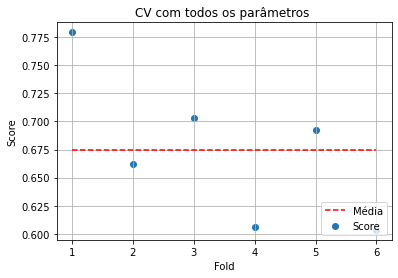

In [23]:
folds = 6
scores = cross_val_score(reg,xTrain,yTrain,cv=folds)
avgScores = np.mean(scores)

plt.scatter(list(range(1,folds+1)),scores)
plt.plot([1,folds],[avgScores,avgScores],linestyle='--',c='red')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(ticks=list(range(1,folds+1)))
plt.legend(['Média','Score'],loc='lower right')
plt.title('CV com todos os parâmetros ')
plt.grid()
print('Valores de R2 para validação cruzada: {}'.format(scores))
print('Média de R2 para validação cruzada: {}'.format(avgScores))
print('Std todos: {}'.format(np.std(scores)))

Valores de R2 para validação cruzada: [0.67624096 0.75498835 0.59380505 0.56126019 0.71588952 0.64054785]
Média de R2 para validação cruzada: 0.6571219886451954
Std TMax: 0.06692060346111119


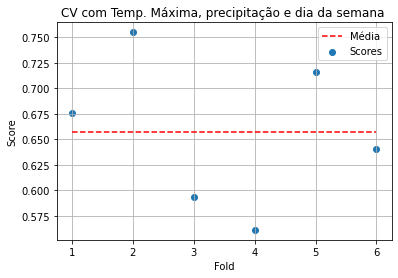

In [24]:
scoresTMax = cross_val_score(regTMax,xTMaxTrain,yTMaxTrain,cv=folds)
avgScoresTMax = np.mean(scoresTMax)
plt.scatter(list(range(1,folds+1)),scoresTMax)
plt.plot([1,folds],[avgScoresTMax,avgScoresTMax],linestyle='--',c='red')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(ticks=list(range(1,folds+1)))
plt.legend(['Média','Scores'],loc='upper right')
plt.title('CV com Temp. Máxima, precipitação e dia da semana ')
plt.grid()
print('Valores de R2 para validação cruzada: {}'.format(scoresTMax))
print('Média de R2 para validação cruzada: {}'.format(avgScoresTMax))
print('Std TMax: {}'.format(np.std(scoresTMax)))

Outra maneira de resolver o problema de multicolinearidade é utilizando a regressão Lasso. [Ela é útil em alguns contextos devido a sua tendência de preferir soluções com menos coeficientes não nulos, reduzindo efetivamente o número de *features* das quais a solução dada depende.](https://scikit-learn.org/stable/modules/linear_model.html#lasso) 

Lasso utiliza um algoritmo que tenta minimizar:

$$\sum_{i=1}^n(y_i-\hat{y_{i}})^2 + \alpha \sum_{i=1}^n|\beta_i|$$

A diferença desse modelo para o anterior reside no termo $\alpha \sum_{i=1}^n|\beta_i|$, onde $\alpha$ é uma constante que deve ser ajustada e $\beta$ são os coeficientes da reta. Quanto maior o valor de $\alpha$ menor deve ser o valor do somatório dos coenficientes, forçando o algoritmo a encontrar soluções com baixos valores de coeficientes podendo inclusive zerá-los. 

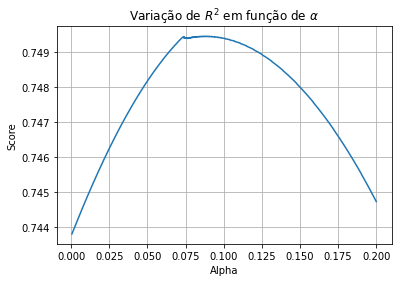

In [25]:
scoresLasso = []
alphas = np.linspace(5e-4,2e-1,num=10000)

for a in alphas:
  regLasso = Lasso(alpha=a)
  regLasso.fit(xTrain,yTrain)
  yPredLasso = regLasso.predict(xTest)
  scoresLasso.append(regLasso.score(xTest,yTest))

plt.plot(alphas,scoresLasso)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title(r'Variação de $R^2$ em função de $\alpha$')
plt.grid()



Utilizando GridsearchCV é possível realizar validação cruzada e fazer o ajuste de hiperparâmetros que são [parâmetros que não são diretamente aprendidos nos estimadores.](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) No nosso caso, os hipermarâmetros são $\alpha$ e normalização.
  [GridsearchCV gera exaustivamente candidatos a partir de uma grade de valores de parâmetros especificados com o parâmetro param_grid.](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
  

In [26]:
alphasCV = np.linspace(5e-4,2e-1,num=10000)
paramGridLasso = {'alpha' : alphasCV,
              'normalize': [True,False]}
regLassoCV= GridSearchCV(Lasso(),cv=folds,param_grid= paramGridLasso)
regLassoCV.fit(xTrain,yTrain)
yPredRegLassoCV = regLassoCV.predict(xTest)
resLassoCV = yPredRegLassoCV - yTest
print('Valor de R2 Lasso: {}'.format(regLassoCV.score(xTest,yTest)))
print('Valor de R2 ajustado Lasso: {}'.format(calculaR2ajustado(regLassoCV.score(xTest,yTest),xTest)))
print('Valor MSE Lasso: {}' .format(mean_squared_error(yTest,yPredRegLassoCV)))
print('Coeficientes : {}'.format(regLassoCV.best_estimator_.coef_))
print('Intercept : {}'.format(regLassoCV.best_estimator_.intercept_))
print('Melhores parâmetros: {}'.format(regLassoCV.best_params_))

Valor de R2 Lasso: 0.7470524287758228
Valor de R2 ajustado Lasso: 0.7348914878515835
Valor MSE Lasso: 5.5173236917080315
Coeficientes : [ 0.05454905 -0.          0.615922   -0.04989285  5.20346178]
Intercept : 6.630047959237995
Melhores parâmetros: {'alpha': 0.003552655265526553, 'normalize': True}


Text(16.8, 4, '$\\mu$ = 0.002\n$\\sigma$ = 2.349')

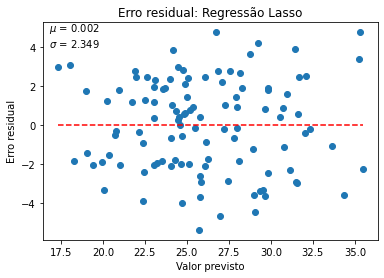

In [34]:
resLassoCV = yPredRegLassoCV - yTest
avgResLassoCV = round(np.mean(resLassoCV),3)
stdResLassoCV = round(np.std(resLassoCV),3)

plt.scatter(yPredRegLassoCV,resLassoCV)
plt.plot([min(yPredRegLassoCV),max(yPredRegLassoCV)],[avgResLassoCV,avgResLassoCV],linestyle='--',c='red')
plt.title('Erro residual: Regressão Lasso')
plt.xlabel('Valor previsto')
plt.ylabel('Erro residual')
plt.text(16.8,4,'$\mu$ = {}\n$\sigma$ = {}'.format(avgResLassoCV,stdResLassoCV))


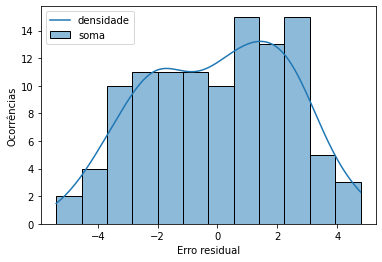

In [46]:
plt.xlabel('Erro residual')
plt.ylabel('Ocorrências')
sns.histplot(data=resLassoCV,kde=True,bins=12)
plt.legend(['densidade','soma'])

Valor de R2 TMax: 0.7584496099737779
Valor de R2 ajustado TMax: 0.7533464327197028
Valor MSE: 5.389983778042867
Coeficientes : [ 0.6428134  -0.056173    5.18885659]
Intercept : 7.035388048622906
Melhores parâmetros: {'normalize': False}


Text(0, 0.5, 'Erro residual')

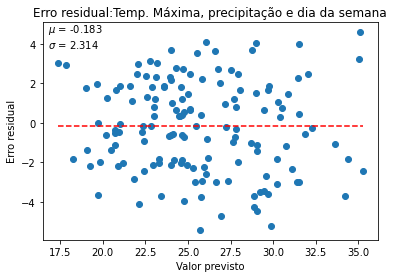

In [32]:
regTMaxCV= GridSearchCV(regTMax,cv=folds,param_grid={'normalize':[True,False]})
regTMaxCV.fit(xTMaxTrain,yTMaxTrain)
yPredTMaxCV = regTMaxCV.predict(xTMaxTest)
resTMaxCV = yPredTMaxCV - yTMaxTest
avgResTMaxCV = round(np.mean(resTMaxCV),3)
stdResTMaxCV = round(np.std(resTMaxCV),3)


print('Valor de R2 TMax: {}'.format(regTMaxCV.score(xTMaxTest,yTMaxTest)))
print('Valor de R2 ajustado TMax: {}'.format(calculaR2ajustado(regTMaxCV.score(xTMaxTest,yTMaxTest),xTMaxTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMaxTest,yPredTMaxCV)))
print('Coeficientes : {}'.format(regTMaxCV.best_estimator_.coef_))
print('Intercept : {}'.format(regTMaxCV.best_estimator_.intercept_))
print('Melhores parâmetros: {}'.format(regTMaxCV.best_params_))

plt.scatter(yPredTMaxCV,resTMaxCV)
plt.plot([min(yPredTMaxCV),max(yPredTMaxCV)],[avgResTMaxCV,avgResTMaxCV],linestyle='--',c='red')
plt.text(16.8,3.8,'$\mu$ = {}\n$\sigma$ = {}'.format(avgResTMaxCV,stdResTMaxCV))
plt.title('Erro residual:Temp. Máxima, precipitação e dia da semana')
plt.xlabel('Valor previsto')
plt.ylabel('Erro residual')


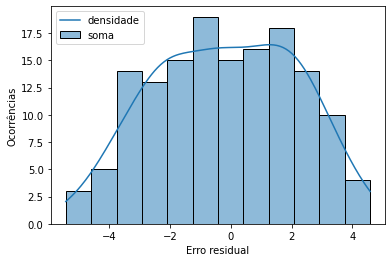

In [47]:
plt.xlabel('Erro residual')
plt.ylabel('Ocorrências')
sns.histplot(data=resTMaxCV,kde=True,bins=12)
plt.legend(['densidade','soma'])

#**Considerações finais**

Os modelos Lasso e regressão com temperatura máxima foram os que apresentaram  melhor desempenho. Seus valores de $R^2$ ajustado foram de aproximadamente 0.7349 e 0.7533, respectivamente. O modelo com temperatura máxima obteve valor de $MSE\approx$ 5.3900 , menor que Lasso que obteve 5.5173. Outra informação que vale ser ressaltada se refere à seleção de *features*. Enquanto Lasso faz uso de quatro *features* (temperatura média, temperatura máxima, precipitação e dia da semana) o outro modelo faz uso de três (temperatura máxima, precipitação e dia da semana), sendo o último menos complexo.
